1. **INSTALLAZIONE PYSPARK**

In [ ]:
# Run below commands in google colab
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark3.0.0
!wget -q http://apache.osuosl.org/spark/spark-3.4.3/spark-3.4.3-bin-hadoop3.tgz
# unzip it
!tar xf spark-3.4.3-bin-hadoop3.tgz
# install findspark
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.3-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
# Verify the Spark version running on the virtual cluster
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate()

assert  "3." in sc.version, "Verify that the cluster Spark's version is 3.x"

In [ ]:
print("Spark version:", sc.version)

Spark version: 3.4.3


2. **CARICAMENTO DATASET DA KAGGLE**

In [ ]:
###########################
# IMPORT
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import copy
from pyspark.sql.functions import col, count, sum, when, round, coalesce, lit, desc, countDistinct, year
from pyspark.sql import SparkSession
import plotly.graph_objs as go
from plotly.subplots import make_subplots
######################################

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giovanniriccardi","key":"a8ad0453159c1984053019f32c3e8392"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                              title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                          1MB  2024-04-10 09:48:38          15161        317  1.0              
sahirmaharajj/school-student-daily-attendance                    School Student Daily Attendance                      2MB  2024-04-29 19:29:56           2781         56  1.0              
kapturovalexander/time-series-for-online-store                   🏪🏬🪫 Electronic store sales data                      9MB  2024-04-30 09:33:41           1045         28  1.0              
fahadrehman07/retail-transaction-dataset                    

In [ ]:
! kaggle datasets download -d davidcariboo/player-scores

Dataset URL: https://www.kaggle.com/datasets/davidcariboo/player-scores
License(s): CC0-1.0
 92% 137M/148M [00:01<00:00, 107MB/s]
100% 148M/148M [00:01<00:00, 102MB/s]


3. **Unzip Dataset**

In [ ]:
!unzip player-scores.zip

Archive:  player-scores.zip
  inflating: appearances.csv         
  inflating: club_games.csv          
  inflating: clubs.csv               
  inflating: competitions.csv        
  inflating: game_events.csv         
  inflating: game_lineups.csv        
  inflating: games.csv               
  inflating: player_valuations.csv   
  inflating: players.csv             


## **ANALYTICS SU DATASET TRANSFERMARKT**

*Il dataset scelto, disponibile su Kaggle al link (https://www.kaggle.com/datasets/davidcariboo/player-scores), è un insieme di dati relativi al calcio, che include:*


*  *Oltre 60.000 partite da molte stagioni in tutte le competizioni principali.*
*   *Più di 400 club provenienti da tali competizioni.*
*  *Oltre 30.000 giocatori appartenenti a tali club.*
*   *Oltre 400.000 record storici delle valutazioni di mercato dei giocatori.*
*   *Più di 1.200.000 record delle presenze dei giocatori in tutte le partite.*


*I dati sono puliti, strutturati e aggiornati automaticamente, provenienti da Transfermarkt, una fonte affidabile per le informazioni sul calcio.*

*Il dataset è composto da diversi file CSV con informazioni su competizioni, partite, club, giocatori e presenze, che vengono aggiornati automaticamente una volta alla settimana. Ogni file contiene gli attributi dell'entità e gli ID che possono essere utilizzati per unirli insieme.*

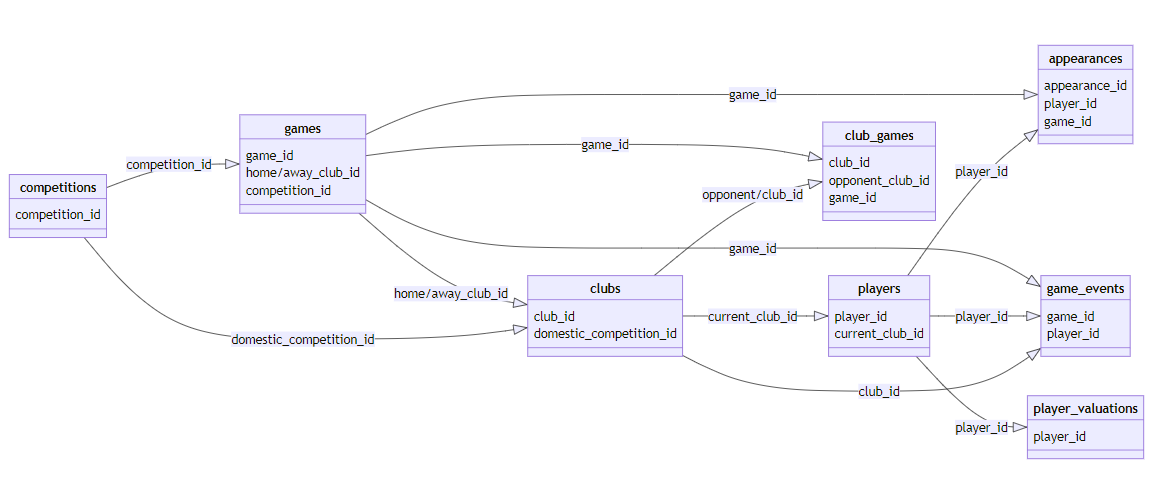


3. **Utilizzo di PySpark su DataSet di Transfermarkt**

In [ ]:
# Inizializzazione della sessione Spark
spark = SparkSession.builder \
    .appName("PySpark_Transfermarkt") \
    .getOrCreate()


In [ ]:
# Definizione dei percorsi dei file
file_locations = {
    "game_events": "/content/game_events.csv",
    "player_valuations": "/content/player_valuations.csv",
    "appearances": "/content/appearances.csv",
    "club_games": "/content/club_games.csv",
    "players": "/content/players.csv",
    "clubs": "/content/clubs.csv",
    "games": "/content/games.csv",
    "competition": "/content/competitions.csv",
    "game_lineups": "/content/game_lineups.csv"
}

file_type = "csv"

# Opzioni CSV
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# Lettura dei file e memorizzazione dei DataFrame in un dizionario
dfs = {}
for key, location in file_locations.items():
    dfs[key] = spark.read.format(file_type) \
        .option("inferSchema", infer_schema) \
        .option("header", first_row_is_header) \
        .option("sep", delimiter) \
        .load(location)


for key, df in dfs.items():
    print(f"Schema del DataFrame '{key}':")
    df.printSchema()



Schema del DataFrame 'game_events':
root
 |-- game_event_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- club_id: integer (nullable = true)
 |-- player_id: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- player_in_id: integer (nullable = true)
 |-- player_assist_id: integer (nullable = true)

Schema del DataFrame 'player_valuations':
root
 |-- player_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- market_value_in_eur: integer (nullable = true)
 |-- current_club_id: integer (nullable = true)
 |-- player_club_domestic_competition_id: string (nullable = true)

Schema del DataFrame 'appearances':
root
 |-- appearance_id: string (nullable = true)
 |-- game_id: integer (nullable = true)
 |-- player_id: integer (nullable = true)
 |-- player_club_id: integer (nullable = true)
 |-- player_current_club_id: integer (n

# 3. **ALLENATORI**

3.1 **Allenatori che hanno vinto più partite dalla stagione 2020 fino ad oggi**

In [ ]:
top_manager_winner = dfs["club_games"].join(dfs["games"], "game_id") \
                          .filter((col("own_manager_name").isNotNull()) & (col("season") >= 2020) & (col("is_win") == 1)) \
                          .groupBy("own_manager_name").agg(count("is_win").alias("num_vittorie")) \
                          .withColumnRenamed("own_manager_name", "manager") \
                          .orderBy(col("num_vittorie").desc())

top_manager_winner.show(5)

# Estrai i dati dal DataFrame
managers = top_manager_winner.select("manager").rdd.flatMap(lambda x: x).collect()
num_vittorie = top_manager_winner.select("num_vittorie").rdd.flatMap(lambda x: x).collect()

# Creazione del grafico a barre utilizzando Plotly
fig = go.Figure(go.Bar(
    x=managers[:5],
    y=num_vittorie[:5],
    marker_color='skyblue'
))

fig.update_layout(
    title='Top 5 Manager per numero di vittorie dal 2020',
    xaxis=dict(title='Manager'),
    yaxis=dict(title='Numero di vittorie')
)

fig.show()


+---------------+------------+
|        manager|num_vittorie|
+---------------+------------+
|  Pep Guardiola|         167|
|  Roger Schmidt|         138|
|Carlo Ancelotti|         138|
|   Erik ten Hag|         137|
|   Jürgen Klopp|         136|
+---------------+------------+
only showing top 5 rows



3.2 **Allenatori che hanno il più alto tasso di cartellini ricevuti su partite giocate**

In [ ]:
# Creazione del DataFrame 'subquery'
subquery_df = dfs["club_games"].join(dfs["appearances"], "game_id") \
    .join(dfs["games"], "game_id") \
    .select(
        "own_manager_name",
        when(col("red_cards") == 1, 1).otherwise(0).alias("red_cards"),
        when(col("yellow_cards") == 1, 1).otherwise(0).alias("yellow_cards"),
        col("game_id").alias("num_partite")
    ) \
    .filter((col("own_manager_name").isNotNull()) & (col("season") >= 2020)) \
    .withColumn("num_partite", when((col("red_cards") == 0) & (col("yellow_cards") == 0), col("num_partite")).otherwise(0))

# Creazione del DataFrame principale con UNION ALL
main_df = subquery_df.select("*").unionAll(
    subquery_df.select(
        "own_manager_name",
        col("red_cards"),
        col("yellow_cards"),
        col("num_partite")
    ).filter(col("yellow_cards") == 1)
).unionAll(
    subquery_df.select(
        "own_manager_name",
        col("red_cards"),
        col("yellow_cards"),
        col("num_partite")
    ).filter((col("red_cards") == 0) & (col("yellow_cards") == 0))
)

# Calcolo dei totali e dei punti totali (1pnt cartellino rosso, 0.5pnt cartellino giallo)
# Maggiore è il punteggio, più l'allenatore ha un gioco "aggressivo"
result_df = main_df.groupBy("own_manager_name").agg(
    sum("red_cards").alias("num_red"),
    sum("yellow_cards").alias("num_yellow"),
    (sum("red_cards") + sum("yellow_cards") * 0.5).alias("total_points"),
    count("num_partite").alias("num_partite_tot")
).filter(col("num_partite_tot") >= 500)

# Calcolo di points_cards4match e ordinamento
result_df = result_df.withColumn("points_cards4match", round(col("total_points") / col("num_partite_tot"), 3)) \
    .orderBy(col("points_cards4match").desc()) \
    .withColumnRenamed("own_manager_name", "manager") \

result_df.show(10)


# Estrai i dati dal DataFrame
managers = result_df.select("manager").rdd.flatMap(lambda x: x).collect()
points_cards4match = result_df.select("points_cards4match").rdd.flatMap(lambda x: x).collect()

# Creazione del grafico a barre utilizzando Plotly
fig = go.Figure(go.Bar(
    x=managers[:10],
    y=points_cards4match[:10],
    marker_color='skyblue'
))

fig.update_layout(
    title='Allenatori con il piu alto tasso di cartellini',
    xaxis=dict(title='Manager'),
    yaxis=dict(title='Points cards 4 match')
)

fig.show()

num_yellow = result_df.select("num_yellow").rdd.flatMap(lambda x: x).collect()
num_red = result_df.select("num_red").rdd.flatMap(lambda x: x).collect()
# Creazione del grafico 3D utilizzando Plotly
fig2 = go.Figure(data=[go.Scatter3d(
    x=managers[:5],
    y=num_yellow[:5],
    z=num_red[:5],
    mode='markers',
    marker=dict(
        size=8,
        color='blue',
        opacity=0.5
    )
)])


fig2.update_layout(
    scene=dict(
        xaxis=dict(title='Manager'),
        yaxis=dict(title='Cartellini gialli'),
        zaxis=dict(title='Cartellini rossi')
    ),
    width=800,  # Imposta la larghezza del grafico
    height=600  # Imposta l'altezza del grafico
)

fig2.show()


+--------------------+-------+----------+------------+---------------+------------------+
|             manager|num_red|num_yellow|total_points|num_partite_tot|points_cards4match|
+--------------------+-------+----------+------------+---------------+------------------+
|      Kirill Novikov|      1|       122|        62.0|            575|             0.108|
|   Franclim Carvalho|     12|       196|       110.0|           1030|             0.107|
|         Rui Vitória|      4|       270|       139.0|           1328|             0.105|
|      Mykola Tsymbal|      0|       104|        52.0|            514|             0.101|
|Aleksandr Khatske...|      0|       248|       124.0|           1230|             0.101|
|       Pepe Bordalás|     20|      1434|       737.0|           7480|             0.099|
|      Álvaro Pacheco|     18|       894|       465.0|           4798|             0.097|
|    João Pedro Sousa|     17|       960|       497.0|           5197|             0.096|
|         

# 4. **MODULI**

4.1 **Moduli con il maggior numero di goal effettuati su partite giocate**

In [ ]:
# Calcolo delle statistiche per la squadra di casa
home_df = dfs['games'].filter(col("home_club_formation").isNotNull()) \
    .groupBy("home_club_formation") \
    .agg({"home_club_goals": "sum", "game_id": "count"}) \
    .withColumnRenamed("sum(home_club_goals)", "home_goals") \
    .withColumnRenamed("count(game_id)", "num_game_home") \
    .select(col("home_club_formation").alias("formation"), "home_goals", "num_game_home")

# Calcolo delle statistiche per la squadra in trasferta
away_df = dfs['games'].filter(col("away_club_formation").isNotNull()) \
    .groupBy("away_club_formation") \
    .agg({"away_club_goals": "sum", "game_id": "count"}) \
    .withColumnRenamed("sum(away_club_goals)", "away_goals") \
    .withColumnRenamed("count(game_id)", "num_game_away") \
    .select(col("away_club_formation").alias("formation"), "away_goals", "num_game_away")

# Unione dei due DataFrame sul campo "formation"
joined_df = home_df.join(away_df, "formation", "left")

# Calcolo delle statistiche finali e filtro
result_df = joined_df.filter((col("num_game_home") + col("num_game_away")) >= 150) \
    .withColumn("goals_tot", coalesce(col("home_goals"), lit(0)) + coalesce(col("away_goals"), lit(0))) \
    .withColumn("num_games", coalesce(col("num_game_home"), lit(0)) + coalesce(col("num_game_away"), lit(0))) \
    .withColumn("goals_for_match", round(col("goals_tot") / col("num_games"), 3)) \
    .orderBy(col("goals_for_match").desc()) \
    .drop("home_goals", "num_game_home", "away_goals", "num_game_away")

result_df.show(5)

# Estrai i dati dal DataFrame
formation = result_df.select("formation").rdd.flatMap(lambda x: x).collect()
goals_for_match = result_df.select("goals_for_match").rdd.flatMap(lambda x: x).collect()

# Creazione del grafico a barre utilizzando Plotly
fig = go.Figure(go.Bar(
    x=formation[:5],
    y=goals_for_match[:5],
    marker_color='skyblue'
))

fig.update_layout(
    title='Moduli con il maggior numero di goal fatti per partita',
    xaxis=dict(title='Formation'),
    yaxis=dict(title='Goals for match')
)

fig.show()


+---------------+---------+---------+---------------+
|      formation|goals_tot|num_games|goals_for_match|
+---------------+---------+---------+---------------+
|        4-1-3-2|      702|      386|          1.819|
|          4-2-4|      332|      188|          1.766|
|          5-2-3|      278|      167|          1.665|
|4-3-3 Defending|    11219|     6923|          1.621|
|          4-3-3|     1221|      767|          1.592|
+---------------+---------+---------+---------------+
only showing top 5 rows



4.2 **Moduli che hanno subito il minor numero di goal su partite giocate**

In [ ]:
# Calcolo delle statistiche per la squadra di casa
home_df = dfs['games'].filter(col("home_club_formation").isNotNull()) \
    .groupBy("home_club_formation") \
    .agg({"away_club_goals": "sum", "game_id": "count"}) \
    .withColumnRenamed("sum(away_club_goals)", "goals_subiti_home") \
    .withColumnRenamed("count(game_id)", "num_game_home") \
    .select(col("home_club_formation").alias("formation"), "goals_subiti_home", "num_game_home")

# Calcolo delle statistiche per la squadra in trasferta
away_df =  dfs['games'].filter(col("away_club_formation").isNotNull()) \
    .groupBy("away_club_formation") \
    .agg({"home_club_goals": "sum", "game_id": "count"}) \
    .withColumnRenamed("sum(home_club_goals)", "goals_subiti_away") \
    .withColumnRenamed("count(game_id)", "num_game_away") \
    .select(col("away_club_formation").alias("formation"), "goals_subiti_away", "num_game_away")

# Unione dei due DataFrame sul campo "formation"
joined_df = home_df.join(away_df, "formation", "left")

# Calcolo delle statistiche finali e filtro
result_df = joined_df.filter((col("num_game_home") + col("num_game_away")) >= 150) \
    .withColumn("goals_subiti_tot", coalesce(col("goals_subiti_home"), lit(0)) + coalesce(col("goals_subiti_away"), lit(0))) \
    .withColumn("num_games", coalesce(col("num_game_home"), lit(0)) + coalesce(col("num_game_away"), lit(0))) \
    .withColumn("goals_received_for_match", round(col("goals_subiti_tot") / col("num_games"), 3)) \
    .orderBy(col("goals_received_for_match").asc()) \
    .drop("goals_subiti_home", "num_game_home", "goals_subiti_away", "num_game_away")

result_df.show(5)

# Estrai i dati dal DataFrame
formation = result_df.select("formation").rdd.flatMap(lambda x: x).collect()
goals_received_for_match = result_df.select("goals_received_for_match").rdd.flatMap(lambda x: x).collect()

# Creazione del grafico a barre utilizzando Plotly
fig = go.Figure(go.Bar(
    x=formation[:5],
    y=goals_received_for_match[:5],
    marker_color='skyblue'
))

fig.update_layout(
    title='Moduli con il minor numero di goal subiti per partita',
    xaxis=dict(title='Formation'),
    yaxis=dict(title='Goals recived for match')
)

fig.show()

+---------------+----------------+---------+------------------------+
|      formation|goals_subiti_tot|num_games|goals_received_for_match|
+---------------+----------------+---------+------------------------+
|        4-1-3-2|             467|      386|                    1.21|
|3-5-2 Attacking|            1054|      796|                   1.324|
|4-3-3 Attacking|           25492|    18556|                   1.374|
| 4-4-2 double 6|           17056|    12261|                   1.391|
|        4-2-3-1|           53753|    38270|                   1.405|
+---------------+----------------+---------+------------------------+
only showing top 5 rows



4.3 **Statistica modulo migliore rispetto a goal fatti e subiti**

In [ ]:
# Calcolo delle statistiche per la squadra di casa
home_df = dfs['games'].filter(col("home_club_formation").isNotNull()) \
    .groupBy("home_club_formation") \
    .agg({"home_club_goals": "sum", "away_club_goals": "sum", "game_id": "count"}) \
    .withColumnRenamed("sum(home_club_goals)", "home_goals") \
    .withColumnRenamed("sum(away_club_goals)", "home_goals_subiti") \
    .withColumnRenamed("count(game_id)", "num_game_home") \
    .select(col("home_club_formation").alias("formation"), "home_goals", "home_goals_subiti", "num_game_home")

# Calcolo delle statistiche per la squadra in trasferta
away_df = dfs['games'].filter(col("away_club_formation").isNotNull()) \
    .groupBy("away_club_formation") \
    .agg({"away_club_goals": "sum", "home_club_goals": "sum", "game_id": "count"}) \
    .withColumnRenamed("sum(away_club_goals)", "away_goals") \
    .withColumnRenamed("sum(home_club_goals)", "away_goals_subiti") \
    .withColumnRenamed("count(game_id)", "num_game_away") \
    .select(col("away_club_formation").alias("formation"), "away_goals", "away_goals_subiti", "num_game_away")

# Unione dei due DataFrame sul campo "formation"
joined_df = home_df.join(away_df, "formation", "left")

# Calcolo delle statistiche finali e filtro
result_df = joined_df.filter((col("num_game_home") + col("num_game_away")) >= 500) \
    .withColumn("goals_tot", coalesce(col("home_goals"), lit(0)) + coalesce(col("away_goals"), lit(0))) \
    .withColumn("goals_subiti_tot", coalesce(col("home_goals_subiti"), lit(0)) + coalesce(col("away_goals_subiti"), lit(0))) \
    .withColumn("num_games", coalesce(col("num_game_home"), lit(0)) + coalesce(col("num_game_away"), lit(0))) \
    .withColumn("goals4match", round(coalesce(col("goals_tot") / col("num_games"), lit(0)), 3)) \
    .withColumn("goals_received4match", round(coalesce(col("goals_subiti_tot") / col("num_games"), lit(0)), 3)) \
    .orderBy(col("goals4match").desc(), col("goals_received4match")) \
    .drop("home_goals", "home_goals_subiti", "num_game_home", "away_goals", "away_goals_subiti", "num_game_away", "goals_tot", "goals_subiti_tot")

result_df.show(5)

# Estrai i dati dal DataFrame
formation = result_df.select("formation").rdd.flatMap(lambda x: x).collect()
goals_received_for_match = result_df.select("goals_received4match").rdd.flatMap(lambda x: x).collect()
goals_for_match = result_df.select("goals4match").rdd.flatMap(lambda x: x).collect()



# Creazione del grafico 3D utilizzando Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=formation[:5],
    y=goals_received_for_match[:5],
    z=goals_for_match[:5],
    mode='markers',
    marker=dict(
        size=8,
        color='blue',
        opacity=0.5
    )
)])

# Aggiunta di titoli e label
fig.update_layout(
    scene=dict(
        xaxis=dict(title='Formation'),
        yaxis=dict(title='Goals 4 Match'),
        zaxis=dict(title='Goals recived 4 Match')
    ),
    width=800,
    height=600
)

fig.show()

+---------------+---------+-----------+--------------------+
|      formation|num_games|goals4match|goals_received4match|
+---------------+---------+-----------+--------------------+
|4-3-3 Defending|     6923|      1.621|               1.484|
|          4-3-3|      767|      1.592|               1.687|
|  4-4-2 Diamond|     1478|      1.581|               1.504|
|4-3-3 Attacking|    18556|      1.577|               1.374|
|          4-4-2|     5343|      1.532|               1.518|
+---------------+---------+-----------+--------------------+
only showing top 5 rows



# 5. **GIOCATORI**

5.1 **Giocatori che hanno effettuato più goal dal 2020 ad oggi**

In [ ]:
# Carica i dati delle partite dalla tabella games
games_df = dfs['games']

# Carica i dati degli eventi delle partite dalla tabella game_events
game_events_df = dfs['game_events'].withColumnRenamed("player_id", "goal_player_id").filter(col('type')=='Goals')

# Carica i dati dei giocatori dalla tabella players
players_df = dfs['players']

# Esegue le join
result_df = games_df.where(col("season") >= 2020) \
            .join(game_events_df, "game_id") \
            .join(players_df, game_events_df["goal_player_id"] == players_df["player_id"]) \
            .groupBy("name") \
            .count() \
            .withColumnRenamed("name", "player") \
            .withColumnRenamed("count", "Goal") \
            .orderBy(col("Goal").desc()) \

result_df.show(5)


# Estrai i dati dal DataFrame
player = result_df.select("player").rdd.flatMap(lambda x: x).collect()
Goal = result_df.select("Goal").rdd.flatMap(lambda x: x).collect()

# Creazione del grafico a barre utilizzando Plotly
fig = go.Figure(go.Bar(
    x=player[:5],
    y=Goal[:5],
    marker_color='skyblue'
))

fig.update_layout(
    title='Giocatori che hanno effettuato piu goal dal 2020',
    xaxis=dict(title='Player'),
    yaxis=dict(title='Goals')
)

fig.show()


+------------------+----+
|            player|Goal|
+------------------+----+
|    Erling Haaland| 158|
|Robert Lewandowski| 155|
|     Kylian Mbappé| 140|
|        Harry Kane| 130|
|     Mohamed Salah| 117|
+------------------+----+
only showing top 5 rows



# 6. **ARBITRI**

6.1 **Arbitri che assegnano il maggior numero di cartellini gialli**

In [ ]:
# DataFrame degli eventi di cartellino giallo
yellow_cards_df = dfs["game_events"].filter(col("type").contains("Cards") & col("description").like("%Yellow%"))

# Aggregazione dei cartellini gialli per arbitro
yellow_cards_count_df = yellow_cards_df.join(dfs["games"], yellow_cards_df["game_id"] == dfs["games"]["game_id"], "inner") \
    .groupBy("referee") \
    .count() \
    .withColumnRenamed("count", "yellow_cards") \
    .orderBy(col("yellow_cards").desc())

# Conteggio delle partite totali arbitrate dagli arbitri
total_games_arbitrated_df = dfs["games"].groupBy("referee").agg(count("*").alias("total_games")) \
    .filter(col("total_games") >= 250) \
    .orderBy(col("total_games"))

# Unione dei DataFrame e calcolo del rapporto
yellow_cards_ratio_df = yellow_cards_count_df.join(total_games_arbitrated_df, "referee", "inner") \
    .withColumn("average_yellowCards", round(col("yellow_cards") / col("total_games"), 2)) \
    .orderBy(col("average_yellowCards").desc())


yellow_cards_ratio_df.show(5)

# Estrai i dati dal DataFrame
referee = yellow_cards_ratio_df.select("referee").rdd.flatMap(lambda x: x).collect()
average_yellowCards = yellow_cards_ratio_df.select("average_yellowCards").rdd.flatMap(lambda x: x).collect()

# Creazione del grafico a barre utilizzando Plotly
fig = go.Figure(go.Bar(
    x=referee[:5],
    y=average_yellowCards[:5],
    marker_color='skyblue'
))

fig.update_layout(
    title='Arbitri che assegnano il maggior numero di cartellini gialli',
    xaxis=dict(title='Referee'),
    yaxis=dict(title='Average yellow Cards')
)

fig.show()

+--------------------+------------+-----------+-------------------+
|             referee|yellow_cards|total_games|average_yellowCards|
+--------------------+------------+-----------+-------------------+
|      Daniele Orsato|         536|        289|               1.85|
|Alejandro Hernánd...|         488|        272|               1.79|
|   Jesús Gil Manzano|         527|        332|               1.59|
|Vladislav Bezborodov|         433|        272|               1.59|
|        Felix Zwayer|         422|        287|               1.47|
+--------------------+------------+-----------+-------------------+
only showing top 5 rows



6.2 **Arbitri che assegnano il maggior numero di cartellini rossi**

In [ ]:
# DataFrame degli eventi di cartellino rosso
red_cards_df = dfs["game_events"].filter(col("type").contains("Cards") & col("description").like("%Red%"))

# Aggregazione dei cartellini rossi per arbitro
red_cards_count_df = red_cards_df.join(dfs["games"], red_cards_df["game_id"] == dfs["games"]["game_id"], "inner") \
    .groupBy("referee") \
    .count() \
    .withColumnRenamed("count", "red_cards") \
    .orderBy(col("red_cards").desc())

# Conteggio delle partite totali arbitrate dagli arbitri
total_games_arbitrated_df = dfs["games"].groupBy("referee").agg(count("*").alias("total_games")) \
    .filter(col("total_games") >= 250) \
    .orderBy(col("total_games"))

# Unione dei DataFrame e calcolo del rapporto
red_cards_ratio_df = red_cards_count_df.join(total_games_arbitrated_df, "referee", "inner") \
    .withColumn("average_redCards", round(col("red_cards") / col("total_games"), 2)) \
    .orderBy(col("average_redCards").desc())


red_cards_ratio_df.show(5)

# Estrai i dati dal DataFrame
referee = red_cards_ratio_df.select("referee").rdd.flatMap(lambda x: x).collect()
average_redCards = red_cards_ratio_df.select("average_redCards").rdd.flatMap(lambda x: x).collect()

# Creazione del grafico a barre utilizzando Plotly
fig = go.Figure(go.Bar(
    x=referee[:5],
    y=average_redCards[:5],
    marker_color='skyblue'
))

fig.update_layout(
    title='Arbitri che assegnano il maggior numero di cartellini rossi',
    xaxis=dict(title='Referee'),
    yaxis=dict(title='Average red Cards')
)

fig.show()

+--------------+---------+-----------+----------------+
|       referee|red_cards|total_games|average_redCards|
+--------------+---------+-----------+----------------+
|Clément Turpin|       28|        308|            0.09|
|Benoît Bastien|       21|        275|            0.08|
|  Bobby Madden|       16|        270|            0.06|
|Sergey Karasev|       16|        277|            0.06|
|  Felix Zwayer|       13|        287|            0.05|
+--------------+---------+-----------+----------------+
only showing top 5 rows



# 7. **CURIOSITA'**

7.1 **Quante partite ha vinto il Napoli con in campo Mario Rui dal 1°minuto?**

In [ ]:
# Applicazione delle condizioni di join e delle condizioni di filtro
result = dfs['club_games'].join(dfs['clubs'], dfs['club_games']["club_id"] == dfs['clubs']["club_id"]) \
    .join(dfs['game_lineups'],  dfs['club_games']["game_id"] ==  dfs['game_lineups']["game_id"]) \
    .where((dfs['clubs']["name"].like("%Napoli%")) &
           (dfs['game_lineups']["player_name"] == "Mário Rui") &
           (col("is_win") == 1) &
           (col("type") == "starting_lineup")) \
    .groupBy("player_name") \
    .agg(count(dfs['club_games']["game_id"]).alias("winning_match")) \
    .select("player_name", "winning_match") \
    .distinct()


result.show()

+-----------+-------------+
|player_name|winning_match|
+-----------+-------------+
|  Mário Rui|          108|
+-----------+-------------+



7.2 **Il Napoli vince più spesso con in campo Mario Rui o Mathías Olivera dal 1°minuto?**

In [ ]:
result = dfs['club_games'].join(dfs['clubs'], dfs['club_games']["club_id"] == dfs['clubs']["club_id"]) \
    .join(dfs['game_lineups'],  dfs['club_games']["game_id"] ==  dfs['game_lineups']["game_id"]) \
    .where(((dfs['clubs']["name"].like("%Napoli%")) &
            ((dfs['game_lineups']["player_name"] == "Mário Rui") | (dfs['game_lineups']["player_name"] == "Mathías Olivera"))) &
           (col("type") == "starting_lineup")) \
    .groupBy("player_name") \
    .agg(count(dfs['club_games']["game_id"]).alias("total_matches"),
         count(when(col("is_win") == 1, True)).alias("winning_matches")) \
    .select("player_name", "total_matches", "winning_matches",
            round((col("winning_matches") / col("total_matches")), 3).alias("winning_ratio")) \
    .distinct()

result.show()

+---------------+-------------+---------------+-------------+
|    player_name|total_matches|winning_matches|winning_ratio|
+---------------+-------------+---------------+-------------+
|      Mário Rui|          181|            108|        0.597|
|Mathías Olivera|           27|             14|        0.519|
+---------------+-------------+---------------+-------------+

